# Customize a TabNet Model

## This tutorial gives examples on how to easily customize a TabNet Model

### 1 - Customizing your learning rate scheduler

Almost all classical pytroch schedulers are now easy to integrate with pytorch-tabnet

### 2 - Use your own loss function

It's really easy to use any pytorch loss function with TabNet, we'll walk you through that


### 3 - Customizing your evaluation metric and evaluations sets

Like XGBoost, you can easily monitor different metrics on different evaluation sets with pytorch-tabnet

In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

### Download census-income dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [5]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

### Load data and split

In [6]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

### Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


### Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# 1 - Customizing your learning rate scheduler

TabNetClassifier, TabNetRegressor and TabNetMultiTaskClassifier all takes two arguments:
- scheduler_fn : Any torch.optim.lr_scheduler should work
- scheduler_params : A dictionnary that contains the parameters of your scheduler (without the optimizer)

----
NB1 : Some schedulers like torch.optim.lr_scheduler.ReduceLROnPlateau depend on the evolution of a metric, pytorch-tabnet will use the early stopping metric you asked (the last eval_metric, see 2-) to perform the schedulers updates

EX1 : 
```
scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params={"mode":'max', # max because default eval metric for binary is AUC
                 "factor":0.1,
                 "patience":1}
```

-----
NB2 : Some schedulers require updates at batch level, they can be used very easily the only thing to do is to add `is_batch_level` to True in your `scheduler_params`

EX2:
```
scheduler_fn=torch.optim.lr_scheduler.CyclicLR
scheduler_params={"is_batch_level":True,
                  "base_lr":1e-3,
                  "max_lr":1e-2,
                  "step_size_up":100
                  }
```

-----
NB3: Note that you can also customize your optimizer function, any torch optimizer should work

In [9]:
# Network parameters
max_epochs = 20 if not os.getenv("CI", False) else 2
batch_size = 1024
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax', # "sparsemax",
                      )

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


### Training

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# 2 - Use your own loss function

The default loss for classification is torch.nn.functional.cross_entropy

The default loss for regression is torch.nn.functional.mse_loss

Any derivable loss function of the type lambda y_pred, y_true : loss(y_pred, y_true) should work if it uses torch computation (to allow gradients computations).

In particular, any pytorch loss function should work.

Once your loss is defined simply pass it loss_fn argument when defining your model.

/!\ : One important thing to keep in mind is that when computing the loss for TabNetClassifier and TabNetMultiTaskClassifier you'll need to apply first torch.nn.Softmax() to y_pred as the final model prediction is softmaxed automatically.

NB : Tabnet also has an internal loss (the sparsity loss) which is summed to the loss_fn, the importance of the sparsity loss can be mitigated using `lambda_sparse` parameter

In [11]:
def my_loss_fn(y_pred, y_true):
    """
    Dummy example similar to using default torch.nn.functional.cross_entropy
    """
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1-y_true)*torch.log(softmax_pred[:,0])
    logloss += y_true*torch.log(softmax_pred[:,1])
    return -torch.mean(logloss)

# 3 - Customizing your evaluation metric and evaluations sets

When calling the `fit` method you can speficy:
- eval_set : a list of tuples like (X_valid, y_valid)
    Note that the last value of this list will be used for early stopping
- eval_name : a list to name each eval set
    default will be val_0, val_1 ...
- eval_metric : a list of default metrics or custom metrics
    Default : "auc", "accuracy", "logloss", "balanced_accuracy", "mse", "rmse"
    
    
NB : If no eval_set is given no early stopping will occure (patience is then ignored) and the weights used will be the last epoch's weights

NB2 : If `patience<=0` this will disable early stopping

NB3 : Setting `patience` to `max_epochs` ensures that training won't be early stopped, but best weights from the best epochs will be used (instead of the last weight if early stopping is disabled)

In [12]:
from pytorch_tabnet.metrics import Metric

In [13]:
class my_metric(Metric):
    """
    2xAUC.
    """

    def __init__(self):
        self._name = "custom" # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute AUC of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            AUC of predictions vs targets.
        """
        return 2*roc_auc_score(y_true, y_score[:, 1])

In [14]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'val'],
    eval_metric=["auc", my_metric],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    loss_fn=my_loss_fn
) 


c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.95051 | train_auc: 0.60426 | train_custom: 1.20852 | val_auc: 0.61058 | val_custom: 1.22116 |  0:00:05s
epoch 1  | loss: 0.64738 | train_auc: 0.72504 | train_custom: 1.45008 | val_auc: 0.71134 | val_custom: 1.42268 |  0:00:10s
epoch 2  | loss: 0.56918 | train_auc: 0.78815 | train_custom: 1.5763  | val_auc: 0.78441 | val_custom: 1.56882 |  0:00:15s
epoch 3  | loss: 0.51006 | train_auc: 0.83626 | train_custom: 1.67253 | val_auc: 0.83773 | val_custom: 1.67547 |  0:00:20s
epoch 4  | loss: 0.44725 | train_auc: 0.87137 | train_custom: 1.74273 | val_auc: 0.87955 | val_custom: 1.7591  |  0:00:26s
epoch 5  | loss: 0.40949 | train_auc: 0.88563 | train_custom: 1.77126 | val_auc: 0.8901  | val_custom: 1.7802  |  0:00:29s
epoch 6  | loss: 0.38802 | train_auc: 0.901   | train_custom: 1.802   | val_auc: 0.89872 | val_custom: 1.79744 |  0:00:32s
epoch 7  | loss: 0.37924 | train_auc: 0.9074  | train_custom: 1.8148  | val_auc: 0.90604 | val_custom: 1.81207 |  0:00:36s
epoch 8  | loss:

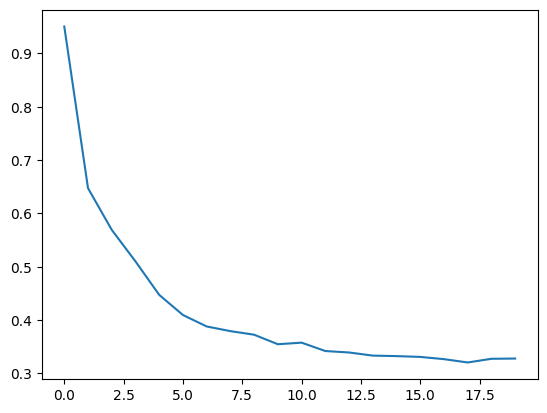

In [15]:
# plot losses
plt.plot(clf.history['loss'])

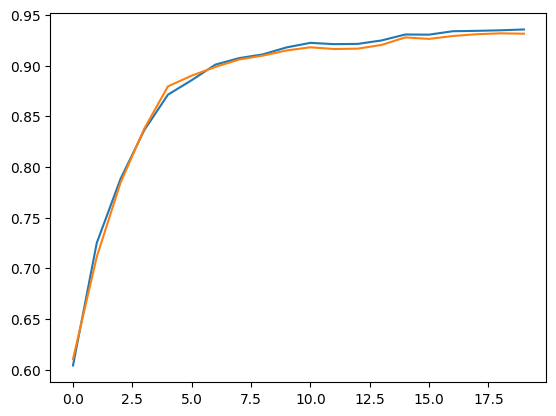

In [16]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['val_auc'])

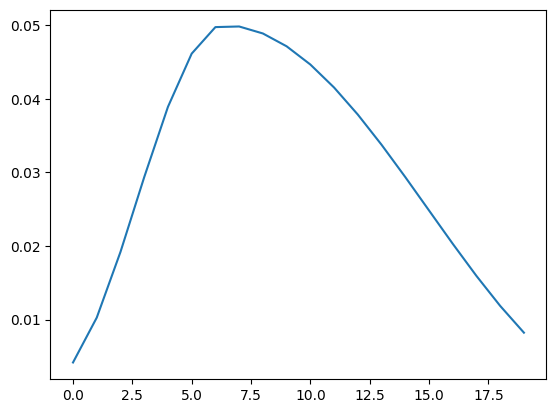

In [17]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [18]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)


print(f"FINAL VALID SCORE FOR {dataset_name} : {clf.history['val_auc'][-1]}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL VALID SCORE FOR census-income : 0.9315072652768986
FINAL TEST SCORE FOR census-income : 0.9272979768298727


In [19]:
# check that last epoch's weight are used
assert np.isclose(valid_auc, clf.history['val_auc'][-1], atol=1e-6)

# Save and load Model

In [20]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [21]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [22]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9272979768298727


In [23]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [24]:
clf.feature_importances_

array([0.17264578, 0.00671072, 0.01214021, 0.05832525, 0.0241633 ,
       0.21146666, 0.10485361, 0.03273227, 0.00100436, 0.02497536,
       0.22535411, 0.07419588, 0.04467806, 0.00675443])

# Local explainability and masks

In [25]:
explain_matrix, masks = clf.explain(X_test)

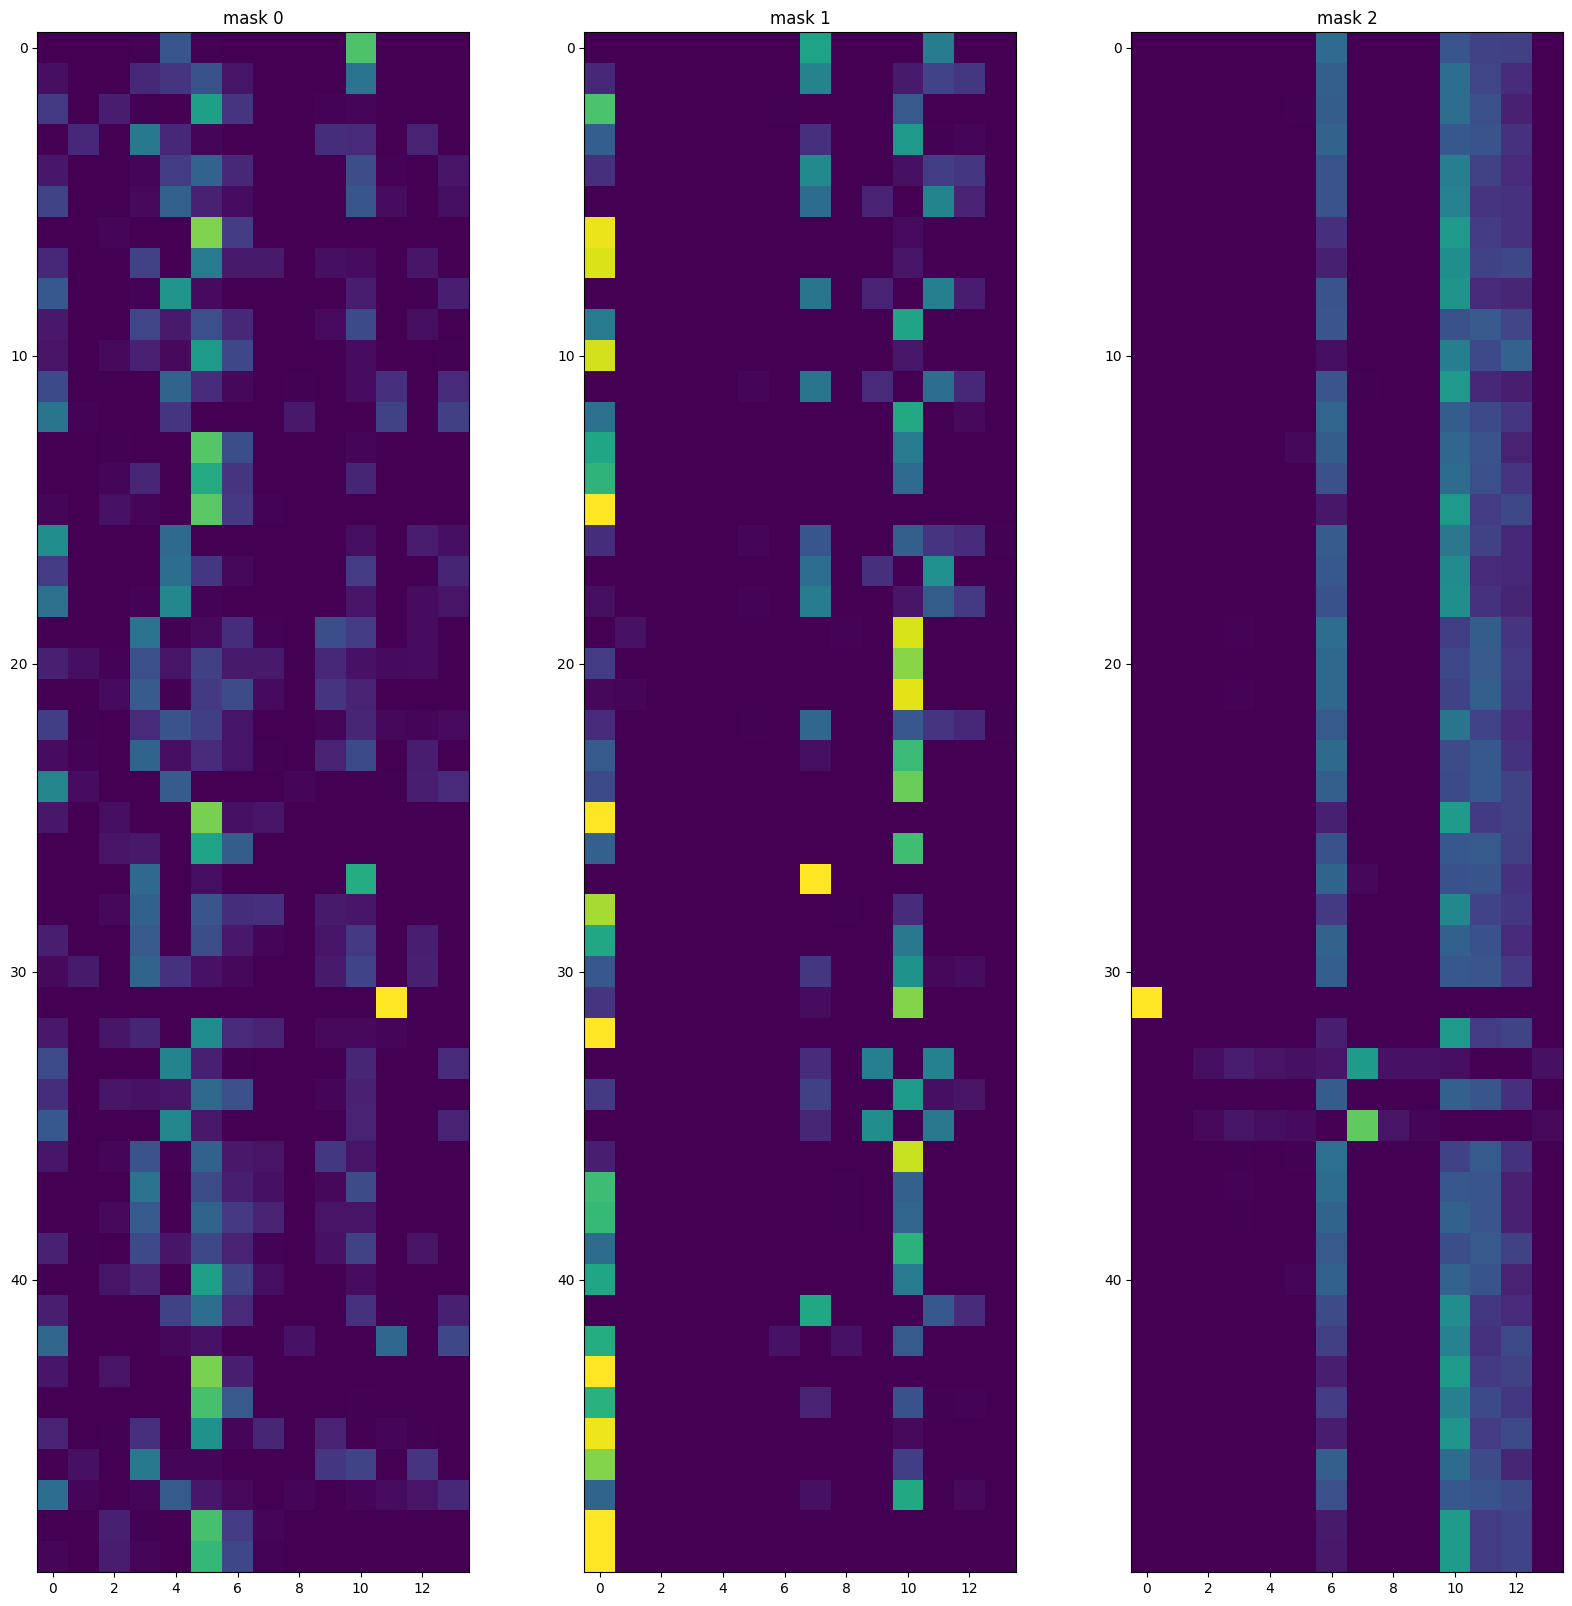

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [28]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-logloss:0.63478
[10]	validation_0-logloss:0.37938


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.31122
[30]	validation_0-logloss:0.28836
[40]	validation_0-logloss:0.27925
[50]	validation_0-logloss:0.27512
[60]	validation_0-logloss:0.27300
[70]	validation_0-logloss:0.27144
[80]	validation_0-logloss:0.27015
[90]	validation_0-logloss:0.27008
[100]	validation_0-logloss:0.27083
[110]	validation_0-logloss:0.27110
[120]	validation_0-logloss:0.27183
[130]	validation_0-logloss:0.27286
[132]	validation_0-logloss:0.27282


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, nthread=None, num_parallel_tree=None, ...)

In [29]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9316018236175305
0.9263032557759232
